In [12]:
from dataclasses import dataclass
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import requests
import matplotlib.pyplot as plt

@dataclass
class GHCNDStationTemps:
    token: str
    stationid: str
    end_date: datetime = datetime.now() - timedelta(days=1)
    years_of_history: int = 5
    endpoint: str = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    _data = None

    def _fetch_data(self):
        if self.end_date is None:
            self.end_date = datetime.now() - timedelta(days=1)

        start_date = self.end_date - relativedelta(years=self.years_of_history)
        current_date = start_date
        all_data = []

        while current_date < self.end_date:
            chunk_end = min(current_date + relativedelta(years=1) - timedelta(days=1), self.end_date)
            params = {
                "datasetid": "GHCND",
                "stationid": self.stationid,
                "datatypeid": "TMAX,TMIN",
                "units": "standard",
                "startdate": current_date.strftime("%Y-%m-%d"),
                "enddate": chunk_end.strftime("%Y-%m-%d"),
                "limit": 1000,
            }

            print(f"Fetching data from {current_date.date()} to {chunk_end.date()}...")
            response = requests.get(self.endpoint, headers={"token": self.token}, params=params)
            response.raise_for_status()

            data = response.json()
            if "results" in data:
                all_data.extend(data["results"])
                print(f"Retrieved {len(data['results'])} records.")
            else:
                print(f"No data found for {current_date.date()} to {chunk_end.date()}.")

            current_date = chunk_end + timedelta(days=1)

        return all_data

    
    @property
    def data(self):
        if self._data is None:
            print("Data is empty. Fetching and converting data...")
            raw_data = self._fetch_data()
            self._data = self._convert_to_dataframe(raw_data)
        return self._data
    

    @staticmethod
    def _convert_to_dataframe(all_data):
        """
        Convert raw data into a pandas DataFrame with 'Date', 'TMAX', and 'TMIN' columns.
        """
        # Convert to DataFrame and handle missing keys/values (e.g., NaN)
        df = pd.DataFrame(all_data)

        # Explicitly keep only the required columns
        columns_to_keep = ['date', 'datatype', 'value']
        if not all(col in df.columns for col in columns_to_keep):
            raise ValueError(f"Input data must contain these columns: {columns_to_keep}")
        
        df = df[columns_to_keep]

        # Pivot the table to get 'datatype' values as columns
        df_pivot = df.pivot(index='date', columns='datatype', values='value')
        # Remove the MultiIndex column formatting by renaming or flattening
        df_pivot.columns.name = None
        df_pivot = df_pivot.reset_index()

        # Convert 'date' column to datetime.date type
        df_pivot['date'] = pd.to_datetime(df_pivot['date']).dt.date

        # Rename columns for better readability
        df_pivot.rename(columns={'TMAX': 'Max Temperature (°C)', 
                                 'TMIN': 'Min Temperature (°C)',
                                 'date': 'Date'},
                                 inplace=True)


        return df_pivot
    
    def plot_temperatures(self):
        if self.data is None or self.data.empty:
            print("No data available to plot.")
            return

        plt.figure(figsize=(10, 6))
        plt.plot(self.data['Date'], self.data['Max Temperature (°C)'], label='Max Temperature (°C)', color='red')
        plt.plot(self.data['Date'], self.data['Min Temperature (°C)'], label='Min Temperature (°C)', color='blue')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.title(f'Temperature Trends for Station {self.stationid}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [13]:
import requests
import os
from dotenv import load_dotenv

load_dotenv()
noaa_token = os.getenv("NOAA_TOKEN")

stationid = "GHCND:USW00014739"
ghcnd = GHCNDStationTemps(noaa_token, stationid)

In [14]:
ghcnd.data

Data is empty. Fetching and converting data...
Fetching data from 2019-11-25 to 2020-11-24...
Retrieved 732 records.
Fetching data from 2020-11-25 to 2021-11-24...
Retrieved 730 records.
Fetching data from 2021-11-25 to 2022-11-24...
Retrieved 730 records.
Fetching data from 2022-11-25 to 2023-11-24...
Retrieved 730 records.
Fetching data from 2023-11-25 to 2024-11-24...
Retrieved 730 records.


,Date,Max Temperature (°C),Min Temperature (°C)
0,2019-11-25,54.0,41.0
1,2019-11-26,63.0,40.0
2,2019-11-27,54.0,40.0
3,2019-11-28,53.0,35.0
4,2019-11-29,44.0,31.0
...,...,...,...
1821,2024-11-19,57.0,45.0
1822,2024-11-20,52.0,41.0
1823,2024-11-21,48.0,45.0
1824,2024-11-22,53.0,43.0


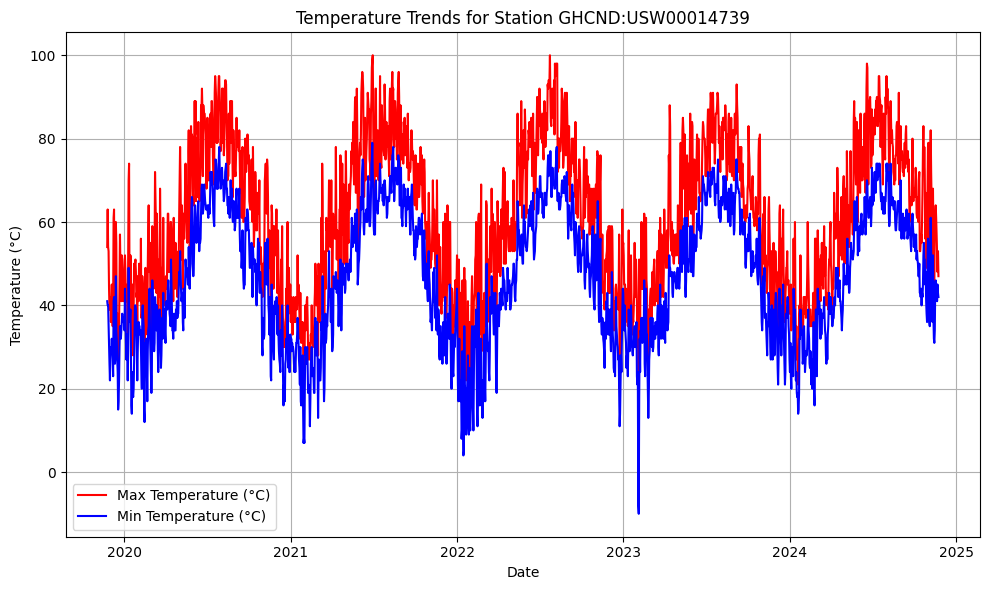

In [15]:
ghcnd.plot_temperatures()

In [70]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [71]:
df = ghcnd.data
df_prophet = df.rename(columns={'Date': 'ds', 'Max Temperature (°C)': 'y'})

In [72]:
model = Prophet(
    yearly_seasonality=True,  # Enable yearly seasonality
    daily_seasonality=False,  # Disable daily seasonality unless needed
    weekly_seasonality=False  # Disable weekly seasonality unless needed
)

In [73]:
# Fit the model
model.fit(df_prophet)

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=365)  # Forecast for the next 30 days
# Predict future values
forecast = model.predict(future)

04:59:02 - cmdstanpy - INFO - Chain [1] start processing
04:59:02 - cmdstanpy - INFO - Chain [1] done processing


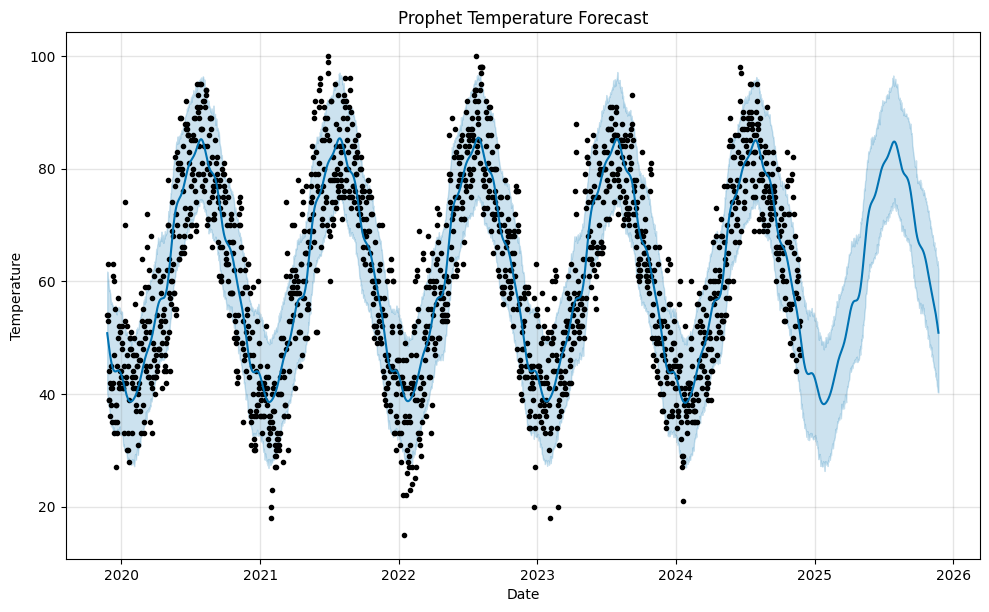

In [74]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Prophet Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

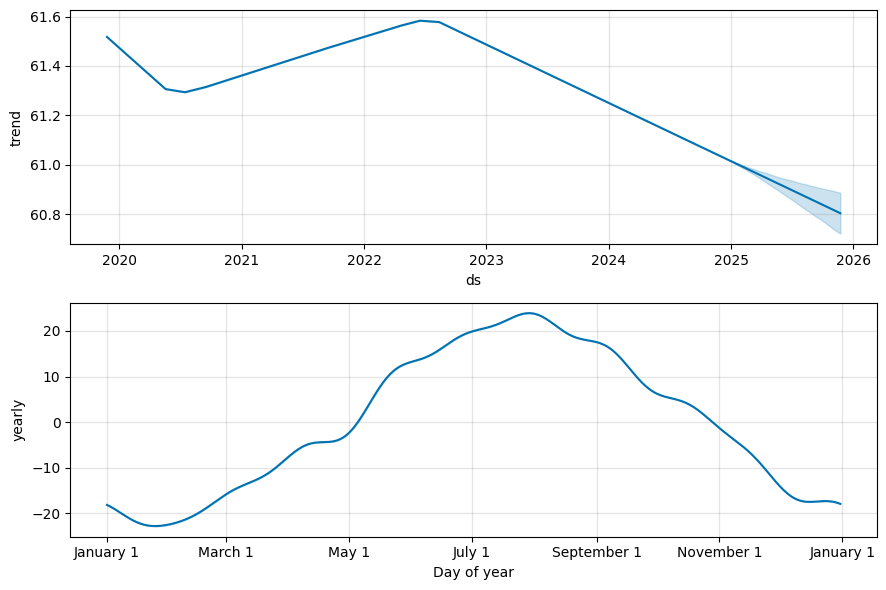

In [67]:
# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

In [68]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Compute performance metrics
metrics = performance_metrics(cv_results)
print(metrics)

  0%|          | 0/5 [00:00<?, ?it/s]

04:57:29 - cmdstanpy - INFO - Chain [1] start processing
04:57:29 - cmdstanpy - INFO - Chain [1] done processing
04:57:29 - cmdstanpy - INFO - Chain [1] start processing
04:57:29 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:00, 12.75it/s]04:57:29 - cmdstanpy - INFO - Chain [1] start processing
04:57:29 - cmdstanpy - INFO - Chain [1] done processing
04:57:29 - cmdstanpy - INFO - Chain [1] start processing
04:57:29 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:00<00:00, 12.15it/s]04:57:29 - cmdstanpy - INFO - Chain [1] start processing
04:57:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

     horizon         mse       rmse       mae      mape     mdape     smape  \
0    37 days   83.300660   9.126920  7.061131  0.139026  0.092977  0.133784   
1    38 days   83.223010   9.122665  7.020666  0.141912  0.091900  0.134840   
2    39 days   82.234627   9.068331  6.974539  0.140858  0.089042  0.133747   
3    40 days   81.721575   9.039999  6.945341  0.139965  0.080039  0.132869   
4    41 days   80.818660   8.989920  6.871765  0.138103  0.080039  0.131166   
..       ...         ...        ...       ...       ...       ...       ...   
324 361 days  103.238184  10.160619  8.516418  0.142192  0.134711  0.140493   
325 362 days  104.051076  10.200543  8.565883  0.142703  0.133370  0.141046   
326 363 days  103.315722  10.164434  8.493252  0.141465  0.132539  0.139903   
327 364 days  104.398590  10.217563  8.579239  0.142999  0.133370  0.141518   
328 365 days  104.972736  10.245620  8.614547  0.144098  0.133370  0.142437   

     coverage  
0    0.768132  
1    0.775824  
2  